In [1]:
! pip install nltk
! pip install pandas
! pip install scikit-learn
! pip install tensorflow[and-cuda]


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from string import punctuation
from nltk import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\viswa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\viswa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\viswa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\viswa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
train_df = pd.read_csv('Dataset/train.csv')

In [4]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [5]:
# %%capture
def data_cleanup(train_df):
    train_df['text'] = train_df['text'].str.lower()
    train_df['text'] = train_df['text'].str.strip()
    train_df['text'] = train_df['text'].replace(to_replace ='http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', value = '', regex = True)
    train_df['text'] = train_df['text'].replace(to_replace ='\?*', value = '', regex = True)
    train_df['text'] = train_df['text'].replace(to_replace ='(RT|rt)', value = '', regex = True)
    train_df['text'] = train_df['text'].replace(to_replace ='@[a-z,_]*', value = '', regex = True)
    train_df['text'] = train_df['text'].replace(to_replace ='([0-9]*:[0-9]*)', value = '', regex = True)
    train_df['text'] = train_df['text'].replace(to_replace ='([0-9]*\.[0-9]*)', value = '', regex = True)
    train_df['text'] = train_df['text'].replace(to_replace ='(utc|gmt)', value = '', regex = True)
    train_df['text'] = train_df['text'].replace(to_replace ='_[\S]', value = '', regex = True)
    train_df['text'] = train_df['text'].replace(to_replace ='&amp;?', value = 'and', regex = False)
    train_df['text'] = train_df['text'].replace(to_replace ='&lt;', value = '<', regex = False)
    train_df['text'] = train_df['text'].replace(to_replace ='&gt;', value = '>', regex = False)
    train_df['text'] = train_df['text'].replace(to_replace ='[ ]{2, }', value = ' ', regex = True)
    train_df['text'] = train_df['text'].replace(to_replace ='([^\w\d ]+)', value = '', regex = True)
    return train_df['text']

In [6]:
# %%capture
train_df['text'] = data_cleanup(train_df)

In [7]:
#Split training dataset
tweet_texts = train_df['text']
class_labels = train_df['target']
train_tweets, test_tweets, train_labels, test_labels = train_test_split(tweet_texts,class_labels,test_size=0.2, random_state=42, stratify=class_labels)
train_tweets, validation_tweets, train_labels, validation_labels = train_test_split(train_tweets, train_labels, test_size = 0.2, random_state = 42, stratify=train_labels)

In [8]:
# train_tweets = train_tweets.str.cat().lower()
# validation_tweets = validation_tweets.str.cat().lower()
# test_tweets = test_tweets.str.cat().lower()


In [9]:
#Text Preprocessor
def preprocessing(text):
   word_lemma = []
   tweet_tokenize = TweetTokenizer()
   tokens = tweet_tokenize.tokenize((text).lower())
   tokens = [w for w in tokens if w not in punctuation and not w.isdigit() and not len(w) < 3]
   stop_words = stopwords.words ('english')
   tweet_without_stopwords = [t for t in tokens if t not in stop_words]
   text = " ".join (tweet_without_stopwords)
   word_lemma = [WordNetLemmatizer().lemmatize(t) for t in tweet_tokenize.tokenize(text)]
   pp_text = " ".join (word_lemma)
   return pp_text

In [10]:
def get_performance_score(actual_label : list, predicted_label : list):
    '''Function to calculate the performance metric using sklearn.
    
    Parameters
    ----------
    actual_label : list
      Actual(Ground Truth) class label from the dataset.
    predicted_label : pd.DataFrame
      Class label predicted by the model
    
    Return
    ------
    f1_score : float
    accuracy : float
    precision : float
    recall : float
    AUROC : float
    '''
    precision = metrics.precision_score(actual_label, predicted_label, pos_label=1)
    recall = metrics.recall_score(actual_label, predicted_label,pos_label=1)
    AUROC = metrics.roc_auc_score(actual_label, predicted_label)
    accuracy = metrics.accuracy_score(actual_label, predicted_label)
    f1_score = metrics.f1_score(actual_label, predicted_label,pos_label=1)
    metrics_list = [f1_score, accuracy, precision, recall, AUROC]
    metrics_list = pd.DataFrame(metrics_list).T
    metrics_df = metrics_list.rename(columns={0:'F1',1:'Accuracy',2:'Precision',3:'Recall',4:'AUROC'})
    return metrics_df

In [11]:
#preprocessing
# train_tweets = preprocessing(train_tweets)
# validation_tweets = preprocessing(validation_tweets)
# test_tweets = preprocessing(test_tweets)

## Variable definitions
 - train_tweets - Preprocessed tweets for training
 - test_tweets - Preprocessed tweets for testing
 - train_labels - class label for training tweets
 - test_labels - class label for test tweets

## Baseline
1. Implement traditional model(MultinomialNB, LogisticRegression, SVC, KNeighborsClassifier) from sklearn
2. Train and test the default model without tuning hyperparameter values
3. Use grid search(GridSearchCV) from sklearn to identify best values for hyperparameters
4. Train the model with best hypermeter values and test it on test set(test_tweets)

# CNN

In [12]:
max(train_df['text'].str.split().apply(lambda x: len(x)))

31

In [13]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras

In [14]:
train_tweets=train_tweets.to_frame()
validation_tweets = validation_tweets.to_frame()
test_tweets = test_tweets.to_frame()

In [15]:
train_tweets['processed_text'] = train_tweets['text'].apply(preprocessing)
validation_tweets['processed_text'] = validation_tweets['text'].apply(preprocessing)
test_tweets['processed_text'] = test_tweets['text'].apply(preprocessing)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(train_tweets['processed_text'])

X_train = vectorizer.transform(train_tweets['processed_text'])
X_val  = vectorizer.transform(validation_tweets['processed_text'])
X_test = vectorizer.transform(test_tweets['processed_text'])
X_train

<4872x10722 sparse matrix of type '<class 'numpy.int64'>'
	with 40492 stored elements in Compressed Sparse Row format>

In [17]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
score = classifier.score(X_val, validation_labels)

print("Accuracy:", score)

Accuracy: 0.8029556650246306


In [18]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [19]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                107230    
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 107241 (418.91 KB)
Trainable params: 107241 (418.91 KB)


Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
from keras.backend import clear_session
clear_session()

In [21]:
X_train = X_train.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()
history = model.fit(X_train, train_labels,
                    epochs=100,
                    verbose=False,
                    validation_data=(X_val, validation_labels),
                    batch_size=10)

In [22]:
loss, accuracy = model.evaluate(X_train, train_labels, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val, validation_labels, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, test_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9875
Validation Accuracy:  0.7340
Testing Accuracy:  0.7216


In [23]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [24]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

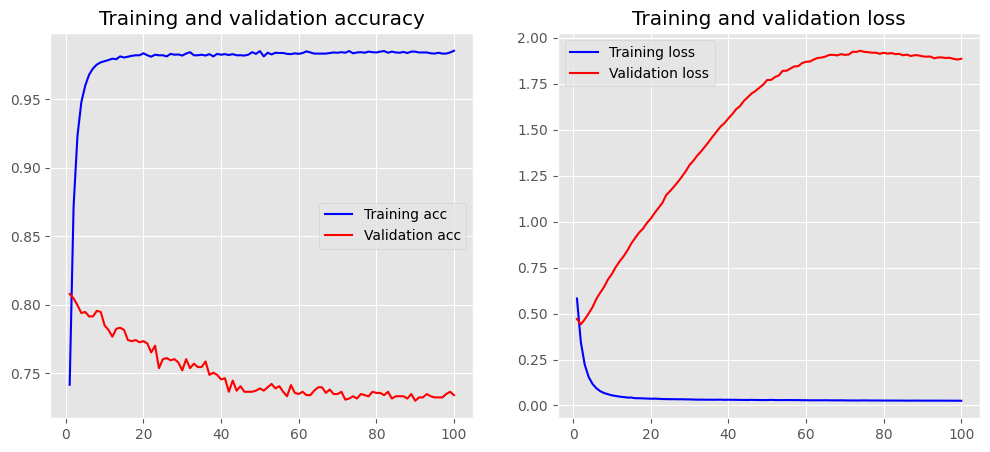

In [25]:
plot_history(history)

In [26]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=18000)
tokenizer.fit_on_texts(train_tweets['processed_text'])

X_train = tokenizer.texts_to_sequences(train_tweets['processed_text'])
X_val = tokenizer.texts_to_sequences(validation_tweets['processed_text'])
X_test = tokenizer.texts_to_sequences(test_tweets['processed_text'])

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(X_train)

[[414, 39, 106, 315, 4203, 2794, 316, 449, 269, 1040, 732, 2795, 863, 7], [270, 733, 290, 206, 2796, 18, 512, 4204, 4205, 207, 1041, 1729], [4206, 1730, 4, 480], [513, 28, 1, 229, 675, 808, 2, 123, 2, 2119, 43, 1149, 553], [4207, 1288, 948, 230, 1289, 1490, 317, 59, 4208, 4209], [1491, 4210, 4211, 864, 389, 1290, 5, 4212, 4213], [21, 676, 53, 629, 4214, 1731, 4215], [291, 1732, 318, 949, 677, 2797, 2120, 2798], [734, 1042, 1733, 161, 4216, 4217, 2799], [168, 2800, 4218, 950, 950, 4219, 950, 358], [319, 1150, 1291, 12, 735, 162], [4220, 208], [1151, 678, 580, 4221], [195, 196], [168, 18, 292, 389, 2121, 24, 320, 736, 4222, 2801], [1043, 415, 23, 2802, 1152, 321], [5, 4223, 809, 737, 481, 1292, 4224], [2803, 738, 110, 53, 147, 158, 4225, 4226, 50, 4227], [1734, 11, 148, 231, 810, 415, 23], [390, 197, 2804, 2805, 2806, 951, 1153, 2807, 1293, 58, 450], [1154, 92, 2808, 9, 1154, 44, 554, 82, 1044, 103, 2, 4228, 250, 62], [209, 182, 739, 132, 320, 4229, 4230, 133, 2122, 630, 1294], [74, 2123

In [27]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 128

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[ 414   39  106  315 4203 2794  316  449  269 1040  732 2795  863    7
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [28]:
clear_session()

# RNN

In [29]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
# model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.add(layers.Dense(10, activation='tanh'))
model.add(layers.Dense(10, activation='gelu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 50)           536250    
                                                                 
 global_max_pooling1d (Glob  (None, 50)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                        

In [30]:
# X_train = X_train.toarray()
# X_val = X_val.toarray()
# X_test = X_test.toarray()

history = model.fit(X_train, train_labels,
                    epochs=2,
                    verbose=False,
                    validation_data=(X_val, validation_labels),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, train_labels, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val, validation_labels, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, test_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9481
Validation Accuracy:  0.8186
Testing Accuracy:  0.8056


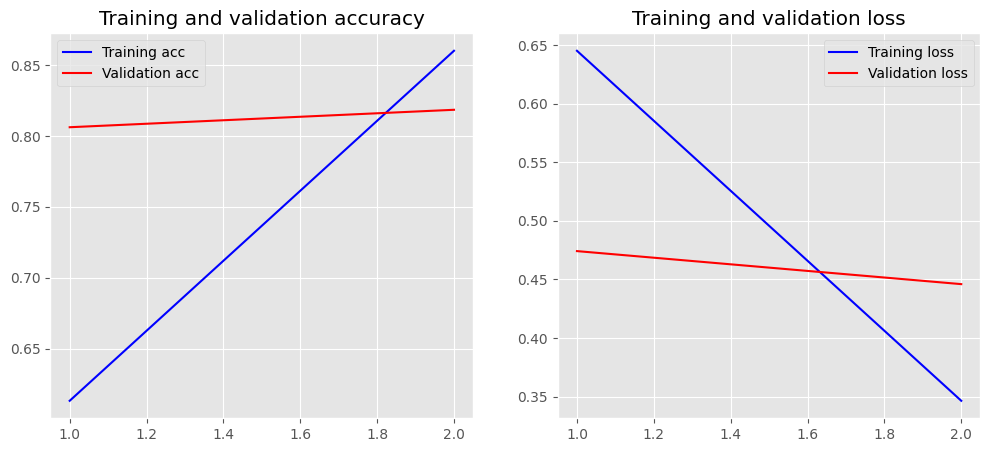

In [31]:
plot_history(history)

In [32]:
import numpy as np

y_test = model.predict(X_test)
y_test

48/48 [==============================] - 0s 1ms/step


array([[0.74627537],
       [0.33214104],
       [0.95598364],
       ...,
       [0.2631417 ],
       [0.06092679],
       [0.05163085]], dtype=float32)

In [33]:
y_test = np.where(y_test > 0.7, 1, 0)
y_test = y_test.flatten()

In [34]:
get_performance_score(test_labels, y_test)

,F1,Accuracy,Precision,Recall,AUROC
0,0.743701,0.806303,0.861167,0.654434,0.787516


# CNN

In [35]:
# A integer input for vocab indices.
inputs = keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(20000, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
# x = layers.Conv1D(128, 7, padding="valid", activation="softmax", strides=3)(x)
# x = layers.Conv1D(128, 7, padding="valid", activation="softmax", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 50)          1000000   
                                                                 
 dropout (Dropout)           (None, None, 50)          0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         44928     
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                             

In [36]:
history = model.fit(X_train, train_labels,
                    epochs=2,
                    verbose=False,
                    validation_data=(X_val, validation_labels),
                    batch_size=10)

In [37]:
loss, accuracy = model.evaluate(X_train, train_labels, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val, validation_labels, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, test_labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9345
Validation Accuracy:  0.7890
Testing Accuracy:  0.7951


In [38]:
y_test = model.predict(X_test)

y_test = np.where(y_test > 0.7, 1, 0)
y_test = y_test.flatten()
get_performance_score(test_labels, y_test)

48/48 [==============================] - 0s 4ms/step


,F1,Accuracy,Precision,Recall,AUROC
0,0.71208,0.791858,0.876957,0.599388,0.768049


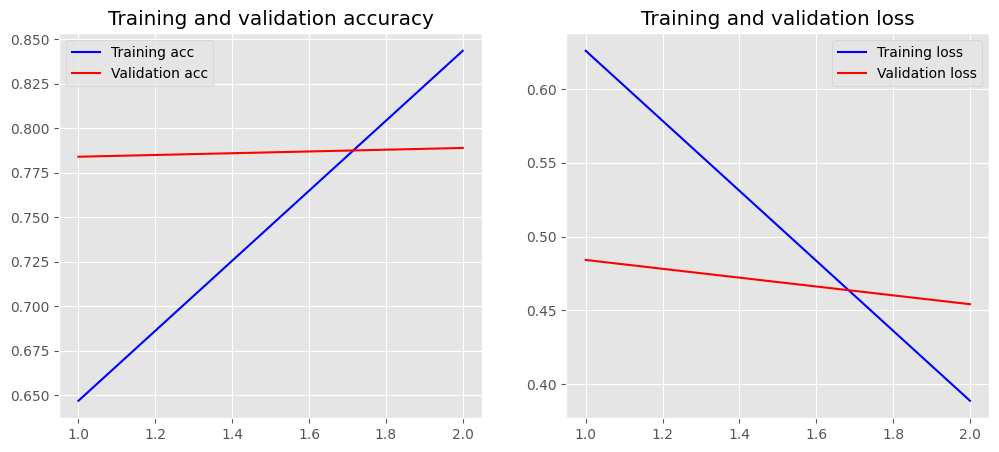

In [39]:
plot_history(history)